# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

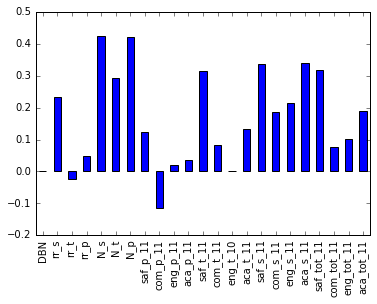

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.show()

# Preliminary-Analysis
- The sat score highly positively correlate with the number of responses recorded for parents, teachers and students
- The parent based scores are significatly lower except the safety and respect score. The teacher based score are notably low and the student based scores are significatly higher on average

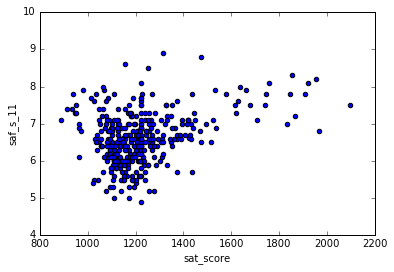

In [12]:
combined.plot.scatter(x="sat_score",y="saf_s_11")
plt.show()

- The sat score is loosely positively 

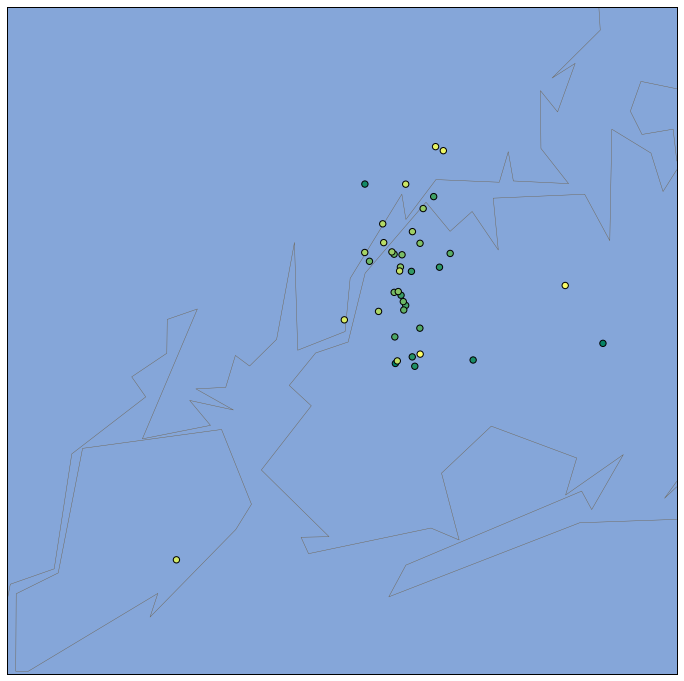

In [13]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(12,12))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
districts_safety=combined.groupby("saf_s_11").agg(numpy.mean).reset_index()
m.scatter(districts_safety["lon"].tolist(),districts_safety["lat"].tolist(),s=40,zorder=2,latlon=True,c=districts_safety["saf_s_11"],cmap="summer")
plt.show()

# Summary
- Most of the districts are situated around the Brookylyn. Most of them are flagged as having a relatively lower safety score.

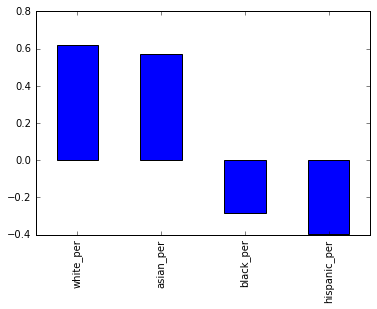

In [14]:
flds=['white_per','asian_per','black_per','hispanic_per']
combined.corr()["sat_score"][flds].plot.bar()

- Schools with more white and asians do better than those with blacks and hispanic students.

-0.396984930781


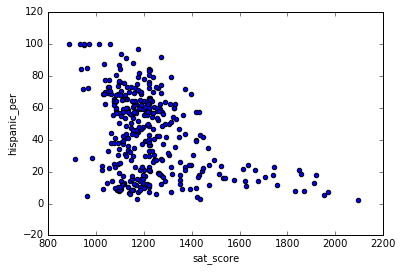

In [17]:
combined[["sat_score","hispanic_per"]].plot.scatter(x="sat_score",y="hispanic_per")
print(combined.corr()['sat_score']['hispanic_per'])
plt.show()

- There is a general tendency for schools with a lower hispanic_per count to perform better in the sat. There is a slight negative correlation between the hispanic population count and the sat score

In [21]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


- all the nameed schools above are public schools but they span across multiple buroughs

In [35]:
print(combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


 - require entry criteria and have a specialised academic discipline

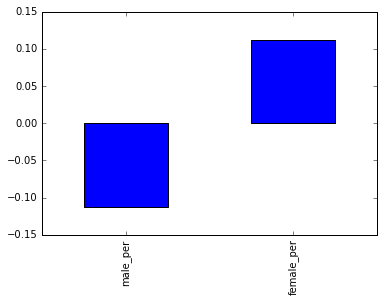

In [36]:
combined.corr()['sat_score'][["male_per","female_per"]].plot.bar()
plt.show()

- schools with a higher percentage of ladies performs better on average those with gents. The sat_score is positively correlated with the female per and inverse of the male

0.112107739422


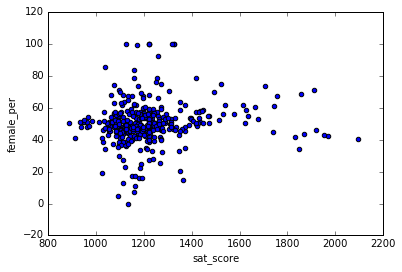

In [37]:
combined[["sat_score","female_per"]].plot.scatter(x="sat_score",y="female_per")
print(combined.corr()['sat_score']['female_per'])
plt.show()

- the records are loosely positively correlated, the higher the percentage of ladies are in a school, the higher the chances of them performing better in the sat

In [38]:
print(combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


- The schools are highly competitive with relatively higher than usual entry criteia. They also tend to have limited class size. They seem to be more specialized

In [41]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]
combined["ap_per"]

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, dtype: flo

0.0571708139077


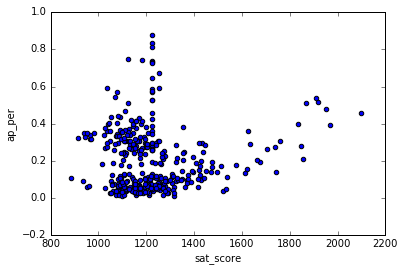

In [42]:
combined[["sat_score","ap_per"]].plot.scatter(x="sat_score",y="ap_per")
print(combined.corr()['sat_score']['ap_per'])
plt.show()

- visually there seems to be a slightly positive correlation between AP test takers percentage to the sat scores however the most of the records are clustered under 1400 in the sat_score. Implies that it is not always an assurance that higher number of AP test takers per school does not imply an averagely higher SAT score

0.38101433081


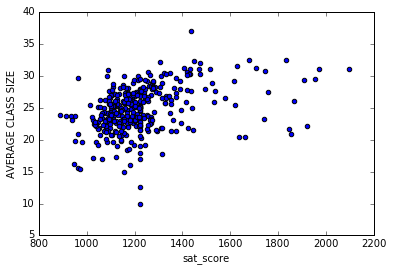

In [45]:
combined[["sat_score","AVERAGE CLASS SIZE"]].plot.scatter(x="sat_score",y="AVERAGE CLASS SIZE")
print(combined.corr()['sat_score']['AVERAGE CLASS SIZE'])
plt.show()

In [ ]:
- The values are highly clustered below 1400 but still show a spoitive correlation implying that larger class sizes result in higher average SAT scores. The competitive nature and need to stand out,in these classes could be the reason